# Towards Bumblebee: An "Affordance" Based Approach in Autonomous Driving

### Contributors in alphabetical order: Duvindu Piyasena, Seima Saki Suriyasekaran, Suprojit Nandy 

## 1. Introduction 

There are two major paradigms for vision-based autonomous driving systems. First is the Imitation Learning, where the input images are directly mapped to the vehicle controls like steering, throttle and break. Second is the Mediated Perception or a Modular Pipeline approach where the entire scene is parsed to make the driving decisions. It involves sub-components to recognize objects such as vehicles in front, traffic light status, pedestrians and lanes. But here the understanding of total scene is unnecessary as the final output is still in low-dimentional space. 

Our approach here is called as "Direct Perception" approach[2-4] which predicts the important parameters, called "Affordances" directly from an image. We predict the following affordances in this model - Front Vehicle distance, Traffic Light Status, Relative Angle with respect to road and the distance between the vehicle and centre of the road.

**About the Dataset**

We use an open-source Simulator called CARLA[1] which supports development, training and validation of autonomous systems. We have designed a client API to to control the vehicle in the scene and extract the ground truth labels from CARLA. The simulation platform resembles an urban environment with pedestrians, vehilces and traffic lights. It also provides a control over the weather condition in a scene and we have utilized this feature in our dataset. The client is available in this link https://github.com/SeimaSaki/Affordance-based-agent-CARLA/tree/master/python_clients and requires the simulator to be installed locally. 

The complete dataset is in onedrive (38 GB) available for download from the link: https://entuedu-my.sharepoint.com/:f:/g/personal/piya0003_e_ntu_edu_sg/ErgZyEIj0xZPvJqx2lAmWSsBTXzOxP1GB0oMM2BlV9CRIA?e=k50Joc

The dataset is divided into 4 parts (xaa/xab/xac/xad.gz.part) and the path where this dataset is located has to be updated in the variable 'DATASET_DIR' in **Section 2.1**. 
It consists of 50,000+ images from two cameras located at left and right corners capturing the front view of the car and its corresponding labels collected from the scene Town 01 and Town 02. 

## 2. Dataset class and Dataloader

<p> This section contains the custom dataset to read the images and map it with the corresponding labels, followed by the dataloader function to instantiate the dataset class. Data is pre-process and the labels are normalized. </p> Following are the major tasks performed to transform the raw data:
<ul>
<li> Images are augmented and transformed to tensors</li>
<li> Affordance labels are normalized by divided each of them with their maximum possible value in the dataset</li>
</ul>

### 2.1 Defines

In [1]:
#Includes the packages to import
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pickle
import sys
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch import optim
import torch.nn as nn
from datetime import datetime
import time
import copy
import argparse
from torch.utils.data import Dataset
from matplotlib import image
from matplotlib import pyplot
from torchvision import transforms
from PIL import Image
import imgaug as ia
import imgaug.augmenters as iaa
import random
import cv2
from collections import OrderedDict

plt.ion()   # interactive mode

#Include the dataset directory path here...
ROOT_DIR               = '/' #Add the root directory path
DATASET_DIR        = ROOT_DIR + 'dataset_paath_here' #add dataset path here


### 2.2 Data Augmentation and Normalization Functions

Raw images are preprocessed before it is fed to the model. The following functions are applied to each image:
<ol>
    <li>Crop - Clip out the top and bottom most part of the image as it contains irrelevant information</li>
    <li>Rescale</li>
    <li>Images are augmented with either of the following functions randomly:
    <ul>
    <li>Gaussian Blur or Average Blur or Median Blur - blur images using gaussian kernels or by computing simple means or median values over neighbourhoods respectively.
    <li>Sharpen - sharpens input images
    <li>Emboss - pronounces highlights and shadows
    <li>Simplex Noise - generates continuous masks following simplex noise and uses them to perform local blending </ul></ol>

The following Affordances are the labels to each of the images. Given an input image the model will directly predict these affordances:
<ol>
    <li>Front Vehicle Distance
        <li>Relative Angle
            <li>Centre Distance
                <li>Traffic Light Status

In [2]:
def get_augmentations():
    # applies the given augmenter in 50% of all cases,
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    seq = iaa.Sequential([
            iaa.SomeOf((0, 4),
                [
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 3.0)),
                        iaa.AverageBlur(k=(2, 7)), 
                        iaa.MedianBlur(k=(3, 11)),
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), 
                    # generate continuous masks following simplex noise and uses them to perform local blending
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),  
                ],
                random_order=True
            )
        ],
        random_order=True
    )
    return seq

class Rescale(object):
    def __init__(self, scalar):
        self.scalar = scalar

    def __call__(self, im):
        w, h = [int(s*self.scalar) for s in im.size]
        return transforms.Resize((h, w))(im)

class Crop(object):
    def __init__(self, box):
        assert len(box) == 4
        self.box = box

    def __call__(self, im):
        return im.crop(self.box)

class Augment(object):
    def __init__(self, seq):
        self.seq = seq

    def __call__(self, im):
        return Image.fromarray(self.seq.augment_images([np.array(im)])[0])

def get_traffic_light_one_hot(traffic_light_state) : 
    if(traffic_light_state[0] == True) : 
        return 0
    else : 
        return 1
    
def find_label_max(pickle_data_l, pickle_data_r) : 
    count                = 0
    max_relative_angle   = 0.0
    l_max_centre_dist    = 0.0
    r_max_centre_dist    = 0.0
    for key, value in pickle_data_l.items() :
        if(abs(value['relative_angle']) > max_relative_angle) : 
            max_relative_angle = abs(value['relative_angle'])                                         
        if(abs(value['centre_dist']) > l_max_centre_dist): 
            l_max_centre_dist  = abs(value['centre_dist'])

    for key, value in pickle_data_r.items() :
        if(abs(value['relative_angle']) > max_relative_angle) : 
            max_relative_angle = abs(value['relative_angle'])                                         
        if(abs(value['centre_dist']) > r_max_centre_dist): 
            r_max_centre_dist  = abs(value['centre_dist'])
    return max_relative_angle, l_max_centre_dist, r_max_centre_dist

### 2.3 Custom Dataset class 

A custom dataset class is designed to fetche the images from the directory and link it with the respective labels in the pickle file. It has 3 functions:
<ol>
    <li>__Init__: Contains the initialization parameters - reading both Left and Right camera images from the directory to obtain the lenght of the function
    <li>__len__: The value over which the dataset class has to be iterated
    <li>__getitem__: Each image is matched with the corresponding label. Images are augmented and transformed and the labels are normalized. </ol>
    
The entire dataset is randomly shuffled and split into 'train' set and 'val' set.

In [3]:
class CARLA_Dataset(Dataset):
    def __init__(self, t, pickle_file_path_l, image_dir_path, image_file_names, pickle_file_path_r):
        #initializing the max range
        self.max_rangle      = 0.0
        self.max_centre_dist = 0.0
        self.max_vdistance   = 50.0
        #initializing transforms
        assert t in ['train', 'val']
        self.transform = get_data_transforms(t)
        ###############LEFT CAMERA##############
        self.image_path = image_dir_path
        self.image_list = os.listdir(image_dir_path)
        self.file_name = image_file_names
        #initialize the labels 
        #read pickle file
        self.pickle_list_l = os.listdir(pickle_file_path_l)
        self.pickled_data_l = {}
        for file in self.pickle_list_l:
            f = open((pickle_file_path_l + file), 'rb')  
            self.pickled_data_l.update(pickle.load(f))
            f.close() 
        ###############RIGHT CAMERA##############
        self.pickle_list_r = os.listdir(pickle_file_path_r)
        self.pickled_data_r = {}
        for file in self.pickle_list_r:
            f = open((pickle_file_path_r + file), 'rb')  
            self.pickled_data_r.update(pickle.load(f))
            f.close() 
        f.close() 
        self.max_rangle, self.l_max_centre_dist, self.r_max_centre_dist \
            = find_label_max(self.pickled_data_l, self.pickled_data_r)

    def __len__(self):
        return len(self.file_name)

    def normalize_labels(self, labels_dict, chk_camera) : 
        labels_dict['front_vehicle']  /= self.max_vdistance
        labels_dict['relative_angle'] /= self.max_rangle
        labels_dict['centre_dist']    /= self.r_max_centre_dist
        return labels_dict
    
    def __getitem__(self, idx):
        frames      = []
        inputs = {}  
        labels = {}
        #####################LEFT CAMERA################
        #reading PIL
        image_name = self.file_name[idx] + '.png'
        raw_image = Image.open(os.path.join(self.image_path, image_name)).convert('RGB')
        #reading file name to access the pickle file
        current_fname = self.file_name[idx]
        chk_camera = current_fname[-3:]

        if chk_camera == '_rt' :
            current_fname_r = current_fname[:-3]
            label_dict = self.pickled_data_r[current_fname_r] 
        else :
            label_dict = self.pickled_data_l[current_fname] 
        label_values = list(label_dict.values())    
      
        #transforming regression labels
        label_dict                    = self.normalize_labels(label_dict, chk_camera)
        labels['front_vehicle']       = torch.Tensor(np.array(float(label_dict['front_vehicle'])))
        labels['centre_dist']         = torch.Tensor(np.array(float(label_dict['centre_dist'])))
        labels['pedestrian_distance'] = torch.Tensor(np.array(float(label_dict['pedestrian_distance'])))
        labels['relative_angle'] = torch.Tensor(np.array(float(label_dict['relative_angle'])))
        
        #transforming classification label - 'traffic_light'
        labels_traffic_light          = get_traffic_light_one_hot(label_dict['traffic_light'])
        labels['traffic_light']       = torch.Tensor(np.array(float(labels_traffic_light)))
        
        
        labels['img_path']            = os.path.join(self.image_path, image_name)
            
        #Augmentation and transformation of raw images
        im = self.transform(raw_image)
        inputs ['sequence'] = im
        return inputs, labels

#dataset support functions
def get_data_transforms(t='train'):
    data_transforms = {
        'train': transforms.Compose([
            Augment(get_augmentations()),
            Crop((0,120,800,480)),
            Rescale(0.4),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
        'val': transforms.Compose([
            Crop((0,120,800,480)),
            Rescale(0.4),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    return data_transforms[t]

def get_train_test_split(image_dir_path): 
    image_list = os.listdir(image_dir_path)
    file_name = []
    for file in image_list:
        file_name.append(os.path.splitext(file)[0])
    random.shuffle(file_name) 

    split_1 = int(0.8 * len(file_name))
    train_filenames = file_name[:split_1]
    test_filenames = file_name[split_1:]
    
    return train_filenames, test_filenames

def get_data(batch_size):
    dataset_dir = DATASET_DIR
    image_dir   = DATASET_DIR + 'camera_images'
    train_filenames, test_filenames = get_train_test_split(image_dir)
    train_ds = CARLA_Dataset( 'train', pickle_file_path_l = dataset_dir+'Left_pickle_file/',
                                       image_dir_path     = dataset_dir+'camera_images/',
                                       image_file_names   = train_filenames, 
                                       pickle_file_path_r = dataset_dir+'Right_pickle_file/')
    val_ds   = CARLA_Dataset( 'val',   pickle_file_path_l = dataset_dir+'Left_pickle_file/',
                                       image_dir_path     = dataset_dir+'camera_images/',
                                       image_file_names   = test_filenames, 
                                       pickle_file_path_r = dataset_dir+'Right_pickle_file/')
    return (
        len(train_ds),
        len(val_ds),
        DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=1),
        DataLoader(val_ds, batch_size=batch_size*2, num_workers=1),
        train_ds,
        val_ds
    )


### 2.4 Data Loader functions for Training and Validation

Dataloader function instantiates the dataset class in two phases - 'train' and 'val'. Images are transformed and the labels are normalized on the fly.

In [4]:
len_train_ds, len_valid_ds, train_dl, valid_dl, train_ds, val_ds = get_data(batch_size=64)

dataloaders   = {'train':train_dl, 'val':valid_dl}
dataset_sizes = {'train':len_train_ds, 'val':len_valid_ds}
print("dataset sizes :", dataset_sizes)

dataset sizes : {'train': 42218, 'val': 10555}


## 3. Training the CNN Models

### 3.1 Util functions for the model

Contains functions to save the checkpoints and resume the model with the necessary checkpoint.

In [5]:
def load_checkpoint(filename) :
    checkpoint = torch.load(filename)
    model_state_dict = checkpoint['model_state_dict']
    optimizer_state_dict = checkpoint['optimizer_state_dict']
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return [model_state_dict, optimizer_state_dict, epoch, loss]

def save_checkpoint(model, optimizer, epoch, loss, filename):
    print("Saving Checkpoint....")
    model_state_dict = model.state_dict()
    optimizer_state_dict = optimizer.state_dict()
    torch.save({
            'epoch': epoch,
            'model_state_dict': model_state_dict,
            'optimizer_state_dict': optimizer_state_dict,
            'loss': loss
            }, filename)
    print("Checkpoint Saved")

def display_image(image) : 
    plt.show(image)
    
def display_torch_im(tensor) : 
    print(tensor.size())
    tensor_img_0 = tensor[0].squeeze(0)
    print(tensor_img_0.size())
    plt.imshow(tensor_img_0.permute(1, 2, 0))
    plt.show()
    
def load_checkpoint_weights(checkpoint, model) :
    print("checkpoint name : ", checkpoint)
    _model_state_dict, _optimizer_state_dict, _epoch, _loss = load_checkpoint(checkpoint)
    model.load_state_dict(_model_state_dict)

def resume_model(checkpoint, model, optimizer) : 
    print("checkpoint name : ", checkpoint)
    _model_state_dict, _optimizer_state_dict, _epoch, _loss = load_checkpoint(checkpoint)
    model.load_state_dict(_model_state_dict)
    optimizer.load_state_dict(_optimizer_state_dict)
    print("Model Resumed Succesfully")


### 3.3 Model for combined for regression and classification prediction

We used the popular CNN models - **Resnet18**, **Resnet50** and **VGG16** for this task. We perform multi-task predictions to infer the 4 affordances as discussed in **Section 2.2**. 

The model outputs for these affordances broadly falls to two categories:

<ul>
    <li>Regression Labels: *Distance to distance of the front vehicle, distance to the centre of the lane and relative angle*
    <li>Classification Label: Traffic Light Status
</ul> The regression loss is computed under **Mean Square Error** criterion, while classification loss is computed using **Cross-Entropy** criterion.

In [6]:
def custom_preds(output, batch_size, num_outputs) : 
    num_pred_outputs = num_outputs-1
    num_regression_outputs = 3
    
    regression_preds     = torch.zeros(batch_size, num_regression_outputs)
    classification_preds = torch.zeros(batch_size) 
    
    regression_preds        = output[:,0:3]
    _, classification_preds = torch.max(output[:,3:5], 1) #.float()
    classification_preds    = classification_preds.T.float()
    classification_preds    = classification_preds.unsqueeze(dim=1)
    return regression_preds, classification_preds
    
def custom_loss(output, target, criterion_dict=None, criterion_vec=None) : 
    regression_loss     = 0.0
    classification_loss = 0.0
    loss     = 0.0
    criterion_mse       = nn.MSELoss()
    criterion_bce_logit = nn.BCEWithLogitsLoss()
    criterion_ce        = nn.CrossEntropyLoss()
    losses              = []
    for i in range(3) : 
        task_regression_loss = criterion_mse(output[:,i], target[:,i])
        regression_loss     += task_regression_loss
        losses.append(task_regression_loss.item())
    classification_target = target[:,3].long()
    classification_target = classification_target #.squeeze(dim=1)
    classification_output = output[:,3:5]
    classification_loss = criterion_ce(classification_output, classification_target)
    losses.append(classification_loss.item())
    loss = regression_loss + classification_loss

    return loss, losses

def custom_error(output, target, criterion_dict=None, criterion_vec=None) : 
    regression_loss     = 0.0
    classification_loss = 0.0
    loss     = 0.0
    criterion_mse       = nn.MSELoss()
    criterion_bce_logit = nn.BCEWithLogitsLoss()
    criterion_ce        = nn.CrossEntropyLoss()
    losses              = []
    for i in range(3) : 
        task_regression_loss = criterion_mse(output[:,i], target[:,i])
        regression_loss     += task_regression_loss
        losses.append(task_regression_loss.item())
    classification_target = target[:,3].long()
    classification_target = classification_target #.squeeze(dim=1)
    classification_output = output[:,3:5]
    _, classification_predicted = classification_output.max(1)
#     print(predicted[0:5], classification_target[0:5])
    classification_corrects = classification_predicted.eq(classification_target).sum().item()
    classification_loss     = criterion_ce(classification_output, classification_target)
#     losses.append(classification_loss.item())
    losses.append(classification_corrects)
    loss = regression_loss + classification_loss

    return loss, losses

#model definitions (combined regression)
def convert_inputs(inputs_old, labels, dim=1):
    inputs               = inputs_old['sequence']
    labels_vdistance     = labels['front_vehicle'] #/50.0
    labels_cdistance     = labels['centre_dist']
    labels_direction     = labels['pedestrian_distance']
    labels_rangle        = labels['relative_angle']
    labels_traffic_light = labels['traffic_light']
    labels_traffic_light = labels_traffic_light#.squeeze(dim=1)
    combined_label       = torch.stack([labels_vdistance, labels_cdistance, labels_rangle, labels_traffic_light], dim=dim)
    return inputs, combined_label

def print_model_output(name, regression_out, classification_out, num_output=5) : 
    print("****** ", name, " ******")
    print("VD : ", regression_out[0:num_output,0].cpu().detach().numpy(), \
          " \nCD : ", regression_out[0:num_output,1].cpu().detach().numpy(), \
          " \nRA : ", regression_out[0:num_output,2].cpu().detach().numpy(), \
          " \nTL : ", classification_out[0:num_output].T.cpu().detach().numpy())
    
def print_model_label(name, label, num_output=5) :
    print("****** ", name, " ******")
    print("VD : ", label[0:num_output,0].cpu().detach().numpy(), \
          " \nCD : ", label[0:num_output,1].cpu().detach().numpy(), \
          " \nRA : ", label[0:num_output,2].cpu().detach().numpy(), \
          " \nTL : ", label[0:num_output,3].cpu().detach().numpy())


device           = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion_vec    = [1,1,0,0]

model_name_list = ['vgg16', 'resnet18', 'resnet50_aug','resnet50']
print("Choose CNN model (Enter No. ) : ")
print("0. VGG16")
print("1. Resnet18")
print("2. Resnet50_aug")
print("3. Resnet50")
model_idx = int(input())
model_name = model_name_list[model_idx]

if(model_idx < 0 or model_idx > len(model_name)) :
    print("Incorrect model selected : ", model_idx, " Expected (0/1/2)")
    
if(model_idx == 0) : 
    print("choosing VGG16....")
    model_ft         = models.vgg16(pretrained=True)
    model_ft.classifier[6].out_features = 5
    optimizer_ft     = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)
elif(model_idx == 1) : 
    print("choosing Resnet18....")
    model_ft         = models.resnet18(pretrained=True)
    num_ftrs         = model_ft.fc.in_features
    model_ft.fc      = nn.Linear(num_ftrs, 5)
    optimizer_ft     = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
elif(model_idx == 2) : 
    print("choosing Resnet50 with augmentations....")
    model_ft         = models.resnet50(pretrained=True)
    num_ftrs         = model_ft.fc.in_features
    model_ft.fc      = nn.Linear(num_ftrs, 5)
    optimizer_ft     = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
else : 
    print("choosing Resnet50....")
    model_ft         = models.resnet50(pretrained=True)
    num_ftrs         = model_ft.fc.in_features
    model_ft.fc      = nn.Linear(num_ftrs, 5)
    optimizer_ft     = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
    
model_ft         = nn.DataParallel(model_ft)
model_ft         = model_ft.to(device)    
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Choose CNN model (Enter No. ) : 
0. VGG16
1. Resnet18
2. Resnet50_aug
3. Resnet50
2
choosing Resnet50 with augmentations....


### 3.4 Model functions to train and test

Checkpoints created during the training are saved in a directory called 'Checkpoints/' which has to be created in the 'ROOT_DIR/' directory.

In [7]:
def train_model(model, dataloaders, dataset_sizes, criterion_dict, criterion_vec, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc       = 0.0
    best_loss      = 0.0
    epoch_acc      = 0.0
    num_outputs    = len(criterion_vec)
    
    train_loss_epoch = []
    val_loss_epoch   = []
     
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase]) :
                inputs_old     = data[0]
                labels         = data[1]
                inputs, labels = convert_inputs(inputs_old ,labels)
                inputs         = inputs.to(device)
                labels         = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                current_batch_size = inputs.size(0)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    regression_preds, classification_preds = \
                              custom_preds(outputs, current_batch_size, num_outputs)
                    loss, losses    = custom_loss(outputs, labels, criterion_dict, criterion_vec)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if(i%20 == 0) :
                            print()
                            print_model_output("preds", regression_preds, classification_preds)
                            print_model_label("labels", labels)
                            print("losses : ", losses)
                            print("loss :", loss.item())

                # statistics
                running_loss += loss.item() * inputs.size(0)

                if(phase == 'val') :
                    if(i%10==0) :
                        print_model_output("preds", regression_preds, classification_preds)
                        print_model_label("labels", labels)
                        print("loss :", loss.item())
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if(phase == 'train') :
                train_loss_epoch.append(epoch_loss)
            elif(phase == 'val') :
                val_loss_epoch.append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train'  :
                checkpoint_name = ROOT_DIR + 'checkpoints/model_' + str(epoch) + '.tar'
                save_checkpoint(model, optimizer, epoch, epoch_loss, checkpoint_name)
        print("\n*********************************")
        print(train_loss_epoch)
        print(val_loss_epoch)
        print("*********************************\n")
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_epoch, val_loss_epoch

def test_model(model, dataloaders, dataset_sizes, criterion_vec):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0
    best_loss = 0.0
    model.eval()   # Set model to evaluate mode
    running_corrects = 0
    running_loss = 0.0
    num_outputs    = len(criterion_vec)
    # Iterate over data.
    running_error_vec = []
    epoch_error_vec   = []
    for i, data in enumerate(dataloaders) :
        inputs = data[0] 
        labels = data[1]
        inputs, labels = convert_inputs(inputs, labels)
        current_batch_size = inputs.size(0)
        if(i%10 == 0) :
            display_torch_im(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            regression_preds, classification_preds = \
                                  custom_preds(outputs, current_batch_size, num_outputs)
            loss, error_vec = custom_error(outputs, labels)
            if(len(running_error_vec) == 0): 
                running_error_vec = np.array(error_vec)
            else : 
                running_error_vec += np.array(error_vec)
            running_loss += loss.item() * inputs.size(0)
            if(i%10 == 0) :
                print_model_output("preds", regression_preds, classification_preds, 1)
                print_model_label("labels", labels, 1)
                print("losses : ", error_vec)
                print("loss   : ", loss)
                print("running error vec : ", running_error_vec)
            
    epoch_loss = 0.0
    epoch_acc  = 0.0
    epoch_loss = running_loss / dataset_sizes
    epoch_error_vec = running_error_vec / dataset_sizes
    
    print('Loss: {:.4f}'.format(
                epoch_loss))
    print("Error of each affordance")
    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, epoch_loss, epoch_error_vec

### 3.5 Training

Inorder to resume a model with a checkpoint the resume_model function has to be called.

In [8]:
#resume_model('/home/seimasakis/CE7454_2019/codes/checkpoints_resnet50_new/model_6.tar', model_ft, optimizer_ft) 
criterion_dict     = {'MSE' : nn.MSELoss, 'CE' : nn.CrossEntropyLoss}
model_final, train_loss_epoch, val_loss_epoch = train_model(model_ft, dataloaders, dataset_sizes, criterion_dict, criterion_vec, optimizer_ft, exp_lr_scheduler, 16)
print(train_loss_epoch)
print(val_loss_epoch)

dump_name = model_name +'_train' #input("Enter test name")
np.savez('../dumps/'+dump_name+'.npz', train_loss=train_loss_epoch, val_loss_epoch=val_loss_epoch)

Epoch 0/15
----------

******  preds  ******
VD :  [ 0.01428312 -0.16823754  0.12290618  0.11320113  0.1582197 ]  
CD :  [ 0.0517145   0.07636637  0.381941    0.10811142 -0.53787196]  
RA :  [-0.07343239 -0.15532959  0.10575525 -0.13611104 -0.03777412]  
TL :  [[0. 1. 0. 0. 1.]]
******  labels  ******
VD :  [1.         1.         1.         0.21752557 1.        ]  
CD :  [0.07274938 0.04737298 0.19260214 0.12608033 0.04383443]  
RA :  [-8.6300331e-01 -8.6314350e-01 -3.0643385e-04 -9.3414281e-05
  4.0606647e-05]  
TL :  [1. 1. 1. 1. 1.]
losses :  [0.40842366218566895, 0.04578355699777603, 0.17568045854568481, 0.6566250324249268]
loss : 1.2865127325057983


KeyboardInterrupt: 

## 4. Testing Model

The testing uses trained models, which can be downloaded from

**link** : https://entuedu-my.sharepoint.com/:f:/g/personal/piya0003_e_ntu_edu_sg/Et4y7G9JbpJOvX1ZxfujXPsBb8ZjygSu_6Ovft2yMGdasQ?e=fHoY6v

The models should be placed in ROOT_DIR + 'checkpoints/' directory and the checkpoint name has to be updated.

checkpoint name :  /home/seimasakis/CE7454_2019/codes/checkpoints_resnet50final/model_15.tar


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 144, 320])
torch.Size([3, 144, 320])


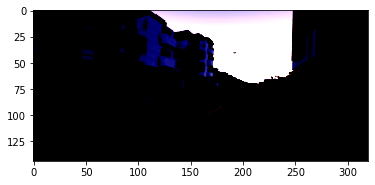

******  preds  ******
VD :  [0.9408632]  
CD :  [0.16503663]  
RA :  [-0.02652082]  
TL :  [[1.]]
******  labels  ******
VD :  [1.]  
CD :  [0.20047936]  
RA :  [-0.01259647]  
TL :  [1.]
losses :  [0.002307337010279298, 0.0018268950516358018, 0.009389819577336311, 128]
loss   :  tensor(0.0151, device='cuda:0')
running error vec :  [2.30733701e-03 1.82689505e-03 9.38981958e-03 1.28000000e+02]


KeyboardInterrupt: 

In [9]:
load_checkpoint_weights(ROOT_DIR +'checkpoints/' +'model_name_here', model_ft)
test_model, test_epoch_loss, test_epoch_error_vec = test_model(model_ft, dataloaders['val'], dataset_sizes['val'], criterion_vec)

print(test_epoch_loss)
print(test_epoch_error_vec)

dump_name = model_name +'_test' #input("Enter test name")
np.savez('../dumps/'+dump_name+'.npz', affordance_error_vec=test_epoch_error_vec, av_error=test_epoch_loss)

### 5. Model Visualizations

In this section we would like to describe the technique we have employed to visualize our model, and how it is learning affordance features described earlier such as the distance to the nearest obstacles as well as the traffic lights.

Among some of the readily available techniques we have looked to employ "GradCAM" or the Gradient Weighted Class Activations Map, a gradient based localization strategy which was proposed by Ramprasaath Ramasamy Selvaraju, et.al. It is one of the most used techniques in visualizing deep networks. 

In this case, we load our model trained on our curated data-set, that we load in as a checkpoint. We then forward pass the image on our model. And notice the forward_pass_selected_layer in which we register a hook to save the corresponding gradients of the layer, whenever the target layer is reached.

Activation mapper then stores the sum of each weight multiplied with their corresponding output, is finally returned by this function GradCam() with prior normalization in place before it.

Hybrid activation mapper function is defined where in it takes the original test image in question and the heat map derived back from the grad cam function defined earlier. It depicts the heat map of high weight of the activation map returned and also superimposes the same on the image to show exactly what affordance feature our model network at that particular layer has managed to learn. We have used a blended weight addition of alpha channel coefficient set to 0.4 corresponding to the heatmap depiction and a beta channel coefficient set to 0.6 for our test image. Gamma channel coefficient set to zero as gradcam takes care of prior normalizations.  

To run the Visualization the corresponding checkpoint has to be loaded, hence the path containing the checkpoint has to be specified in the main function.

True
loss :  tensor(0.1519, device='cuda:0', grad_fn=<AddBackward0>)
144 320


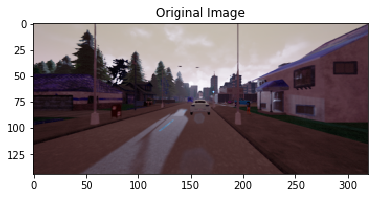

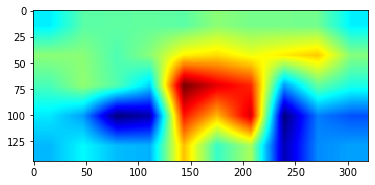

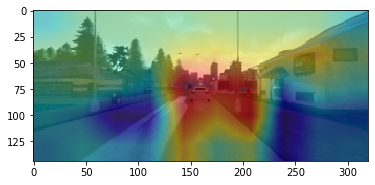

Grad cam completed


In [12]:
class Class_Act_Extractor():
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_selected_layer(self, x):
    
    # Hook Function Definition where the model is forward passed through:
        out_layerput = None
        for module_name, module in self.model._modules.items():
            # Iterates through pen-ultimate stage to return the final activcation map
            if module_name == 'fc':
                return out_layerput, x
            x = module(x)  # Forward
            
            if module_name == self.target_layer:
                print('True')
                x.register_hook(self.save_gradient)
                out_layerput = x  # Save the convolution output on that layer
        return out_layerput, x

    def forward_pass(self, x):
        
        # Forward pass on the convolutions
        out_layerput, x = self.forward_pass_selected_layer(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.fc(x)
        return out_layerput, x

class GradCam():


    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Extractor Definition with Loaded Model Here ::::
        self.extractor = Class_Act_Extractor(self.model, target_layer)

    def generate_cam(self, input_image, target_index=None):
        # Full forward pass
        # out_layerput is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        self.model.train()
        
        out_layerput, model_output = self.extractor.forward_pass(input_image)
        if target_index is None:
            target_index = np.argmax(model_output.data.numpy())

        loss, _ = custom_loss(model_output, target_index)
        print("loss : ", loss)

        # Zero grads
        self.model.fc.zero_grad()

        loss.backward()
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.cpu().data.numpy()[0]
        # Get convolution outputs
        target = out_layerput.cpu().data.numpy()[0]
        # Get weights from gradients
        # Take averages for each gradient
        weights_grad = np.mean(guided_gradients, axis=(1, 2))
        # Create empty numpy array for cam
        activations_mapper = np.ones(target.shape[1:], dtype=np.float32)
        
        for i, w in enumerate(weights_grad):
            activations_mapper += w * target[i, :, :]

        im_height = input_image.size(2)
        im_width  = input_image.size(3)
        print(im_height, im_width)
        activations_mapper = cv2.resize(activations_mapper, (im_width, im_height))
        activations_mapper = np.maximum(activations_mapper, 0) 
        activations_mapper = (activations_mapper - np.min(activations_mapper)) / (np.max(activations_mapper) -
                                     np.min(activations_mapper))  # Normalize between 0-1
        activations_mapper = np.uint8(activations_mapper * 255)  # Scale between 0-255 to visualize
        return activations_mapper

def hybrid_activation_mapper(image_pass_in, activation_map):

    # Resize the Original Image to the image Dimension
    # As is during Data Augmentation
    image_pass_in = image_pass_in [120:480, :]
    image_pass_in =cv2.resize(image_pass_in,None, fx=0.4, fy=0.4,interpolation=cv2.INTER_AREA)
    plt.imshow(image_pass_in)
    plt.title('Original Image')
    plt.show()



    # print(transformed_im.shape)
    # Grayscale activation map

    # Implementation of Heatmap of activation map
    # Application of Color Mapping with reference to the Activations Map it receives  
    activation_heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
    plt.imshow(activation_heatmap)
    plt.show()
    #Label Point Here ::::
    
    #OpenCV Blended Addition Here :::
    
    alpha_weight_index = 0.4
    beta_weight_index  = 0.6
    gamma_index        = 0.0
    
    image_with_heatmap = cv2.addWeighted(activation_heatmap, alpha_weight_index, image_pass_in, beta_weight_index,gamma_index)
    
    plt.imshow(image_with_heatmap)
    plt.show()

# Main Call goes here :::::

if __name__ == '__main__':    
 
    model            = models.resnet50(pretrained=True)
    num_ftrs         = model.fc.in_features
    model.fc         = nn.Linear(num_ftrs, 5)
    #update checkpoint path below
    _model_state_dict, _optimizer_state_dict, _epoch, _loss = load_checkpoint(ROOT_DIR + 'path_here' +'model.tar_here')
    state_dict = _model_state_dict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    model = model.to(device)
    custom_transform = get_data_transforms()
    img, labels = val_ds[600]
    im_path = labels['img_path']
    img_in  = cv2.imread(im_path, 1)
    img, label = convert_inputs(img, labels, dim=0)
    img = img.to(device)
    label = label.to(device)
    img = img.unsqueeze(0)
    label = label.unsqueeze(0)
    image_prep       = img

    
    grad_cam = GradCam(model, target_layer='layer4')
    cam = grad_cam.generate_cam(image_prep, label)
    hybrid_activation_mapper(img_in, cam)
    print('Grad cam completed')

## 6. Plot Results

In [13]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

resnet18_file = np.load('../dumps/resnet18.npz')
vgg16_file    = np.load('../dumps/vgg16.npz')
resnet50_file = np.load('../dumps/resnet50.npz')

resnet18_file_test = np.load('../dumps/resnet18_test.npz')
vgg16_file_test    = np.load('../dumps/vgg16_test.npz')


resnet18_train_loss = resnet18_file['train_loss']
resnet18_test_loss  = resnet18_file['val_loss_epoch']
resnet18_test_error = resnet18_file_test['affordance_error_vec']

vgg16_train_loss = vgg16_file['train_loss']
vgg16_test_loss  = vgg16_file['val_loss_epoch']
vgg16_test_error = vgg16_file_test['affordance_error_vec']

resnet50_train_loss = resnet50_file['train_loss']
resnet50_test_loss  = resnet50_file['val_loss_epoch']


resnet18_train_loss = resnet18_train_loss[0:16]
resnet18_test_loss  = resnet18_test_loss[0:16]

resnet50_train_loss = resnet50_train_loss[0:16]
resnet50_test_loss  = resnet50_test_loss[0:16]

#converting classification accuracy to error
vgg16_test_error[-1]    = 1-vgg16_test_error[-1]
resnet18_test_error[-1] = 1-resnet18_test_error[-1]
resnet50_test_error[-1] = 1-resnet50_test_error[-1]

x_ticks = range(15)
fig = plt.figure()
plt.rcParams.update({'font.size': 12})

plt.plot(resnet18_train_loss, label='train_loss', marker='o')
plt.plot(resnet18_test_loss, label='test_loss', marker='o')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks(x_ticks)
plt.gca().set_title('Resnet18 loss', pad=15, fontsize=20)
lgd = plt.gca().legend()
fig.savefig(ROOT_DIR + 'plots/resnet18_train.svg', bbox_extra_artists=(lgd,), bbox_inches='tight', format='svg', dpi=1200)
plt.show()

x_ticks = range(16)
fig = plt.figure()
plt.rcParams.update({'font.size': 12})
plt.plot(resnet50_train_loss, label='train_loss', marker='o')
plt.plot(resnet50_test_loss, label='test_loss', marker='o')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks(x_ticks)
plt.gca().set_title('Resnet50 loss', pad=15, fontsize=20)
lgd = plt.gca().legend()
fig.savefig(ROOT_DIR + 'plots/resnet50_train.svg', bbox_extra_artists=(lgd,), bbox_inches='tight', format='svg', dpi=1200)
plt.show()

x_ticks = range(16)
fig = plt.figure()
plt.rcParams.update({'font.size': 12})
plt.plot(vgg16_train_loss, label='train_loss', marker='o')
plt.plot(vgg16_test_loss, label='test_loss', marker='o')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks(x_ticks)
plt.gca().set_title('VGG16 loss', pad=15, fontsize=20)
lgd = plt.gca().legend()
fig.savefig(ROOT_DIR + 'plots/vgg16_train.svg', bbox_extra_artists=(lgd,), bbox_inches='tight', format='svg', dpi=1200)
plt.show()

x_ticks = range(16)
fig = plt.figure()
plt.rcParams.update({'font.size': 12})
plt.plot(resnet18_test_loss, label='resnet18', marker='o')
plt.plot(vgg16_test_loss, label='vgg16', marker='o')
plt.plot(resnet50_test_loss, label='resnet50', marker='o')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks(x_ticks)
plt.gca().set_title('Model Comparison', pad=15, fontsize=20)
lgd = plt.gca().legend()
fig.savefig(ROOT_DIR + 'plots/train_model_comparison.svg', bbox_extra_artists=(lgd,), bbox_inches='tight', format='svg', dpi=1200)
plt.show()

# create plot
n_groups = 4
fig = plt.figure()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8
rects1 = plt.bar(index-bar_width, vgg16_test_error, bar_width,
    alpha=opacity,
    color='r',
    label='vgg16')
rects2 = plt.bar(index, resnet18_test_error, bar_width,
    alpha=opacity,
    color='g',
    label='resnet18')
rects3 = plt.bar(index + bar_width, resnet50_test_error, bar_width,
    alpha=opacity,
    color='b',
    label='resnet50')
x_ticks = range(12)
plt.rcParams.update({'font.size': 12})
plt.xlabel('Task')
plt.ylabel('Accuracy (%)')
plt.xticks(index, x_ticks)
plt.legend()
# plt.tight_layout()
lgd = plt.gca().legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1))
plt.show()
fig.savefig(ROOT_DIR + 'plots/test_error_model_comparison.svg', bbox_extra_artists=(lgd,), bbox_inches='tight', format='svg', dpi=1200)

FileNotFoundError: [Errno 2] No such file or directory: '../dumps/resnet18.npz'

#### References:
<ol>
    <li> CARLA Simulator http://carla.org/
    <li> DeepDriving: Learning Affordance for Direct Perception in Autonomous Driving http://deepdriving.cs.princeton.edu/paper.pdf
    <li> End-to-end Driving via Conditional Imitation Learning https://arxiv.org/abs/1710.02410
    <li> Conditional Affordance Learning for Driving in Urban Environments https://arxiv.org/abs/1806.06498
</ol>